# Prediction of Product Sales

##### Jalicia Harris

### Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Filter ALL warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## Setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Set pandas to display more columns
pd.set_option('display.max_columns', 20)

## Load and Inspect Data

In [3]:
# Load file, display column info, and preview rows
df = pd.read_csv('Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Clean Data

### 1. How many rows and columns?


In [4]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 8523 rows, and 12 columns.


### 2. What are the datatypes of each variables?

In [5]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Checking for Duplicates and Missing Values

In [6]:
# Check and delete any duplicates
sale = df.duplicated().sum()
print(f'There are {sale} duplicates')

There are 0 duplicates


In [7]:
# Identify missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Identifying and Making Corrections


- The missing values in column 'Item_Weight' will be replaced with calculated mean.
- This missing values in the 'Outlet_Size' column will be replaced with value "Unknown"
- All other datatypes will remain as is.

In [8]:
# Replace missing values in 'Item Weight' column with the median
missing_data = df['Item_Weight'].mean()
df['Item_Weight'].fillna(missing_data, inplace = True)

In [9]:
# Replace missing values in 'Outlet_Size' column with value 'Unknown'
df['Outlet_Size'].fillna('N/A', inplace=True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Identify and Correct Any Inconsistencies

In [10]:
# Find any inconsistent categories of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [11]:
# Standarize the values in the 'Item_Fat_Content' column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
# Confirm results
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## For any numerical columns, obtain the summary statistics of each (min, max, mean)

In [12]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.23,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,12.86,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


## Exploratory Data Analysis

### Examining Distributions of Various Sections Using Histograms

---



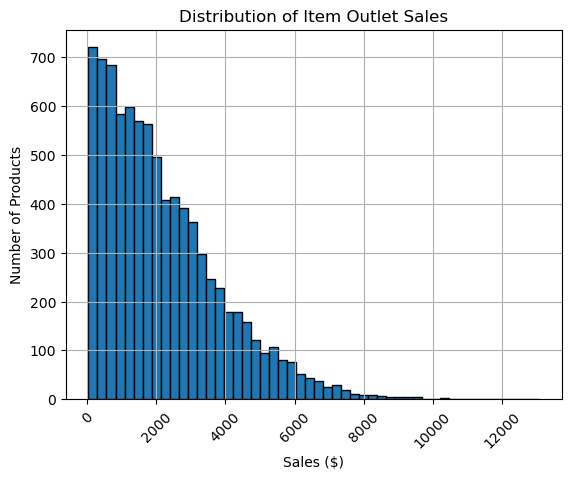

In [13]:
# Create a histogram to view the distributions of various features in the dateset
ax = df['Item_Outlet_Sales'].hist(bins=50, edgecolor = 'black')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Distribution of Item Outlet Sales')
ax.set_xlabel('Sales ($)')
ax.set_ylabel('Number of Products');

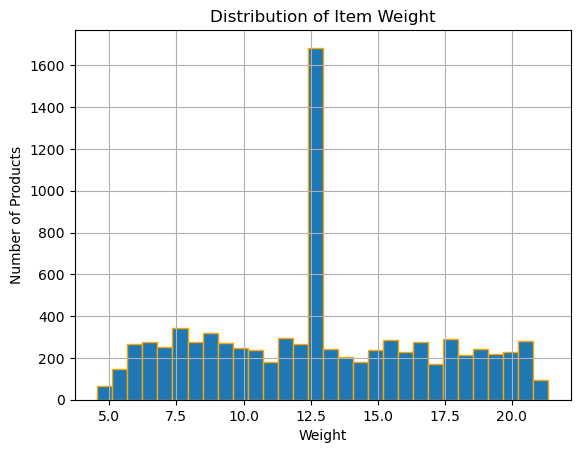

In [14]:
ax = df['Item_Weight'].hist(bins=30, edgecolor = 'orange')
ax.set_title('Distribution of Item Weight')
ax.set_xlabel('Weight')
ax.set_ylabel('Number of Products');

### Examine Statistical Summaries Using Boxplots

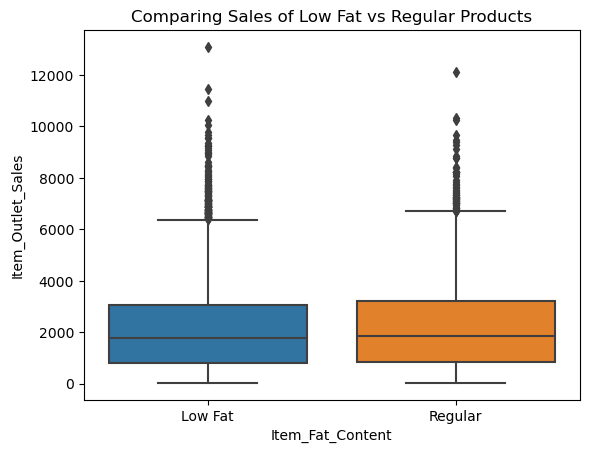

In [15]:
# Create a Boxplot to view statistical summaries of various features in the dataset
ax = sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df)
ax.set_title("Comparing Sales of Low Fat vs Regular Products");

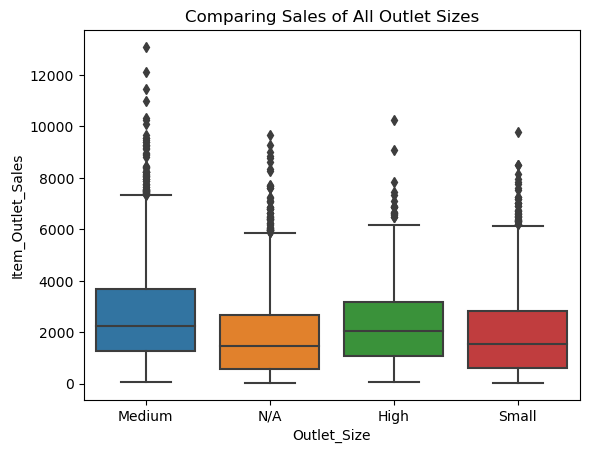

In [16]:
ax = sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df)
ax.set_title("Comparing Sales of All Outlet Sizes");

### Examine the Correlation Between Various Sections Using Heatmaps

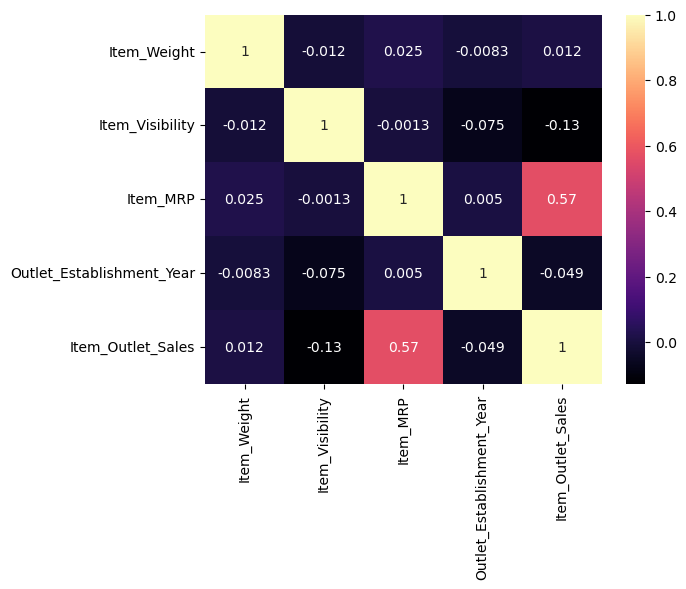

In [17]:
corr = df.corr()
sns.heatmap(corr, cmap = 'magma', annot=True);

## Explanatory Data Analysis

### Possible Questions to Answer:
##### 1. What outlet types have the highest sales?
##### 2. Which product types bring in the most profits?

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### 1. What outlet types have the highest sales?

In [19]:
# Get the average for each outlet type
type_mean = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
type_mean

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

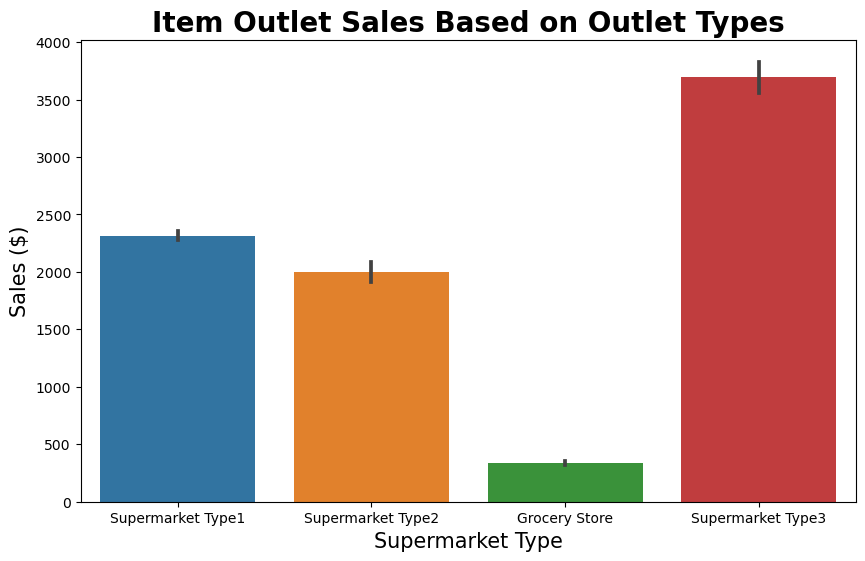

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax.set_title('Item Outlet Sales Based on Outlet Types', fontsize=20, fontweight='bold');
ax.set_xlabel('Supermarket Type', fontsize=15)
ax.set_ylabel('Sales ($)', fontsize=15);

- The bar graph above shows that Supermarket Type 3 has the highest amount of sales.

### What product types bring in the most profits?

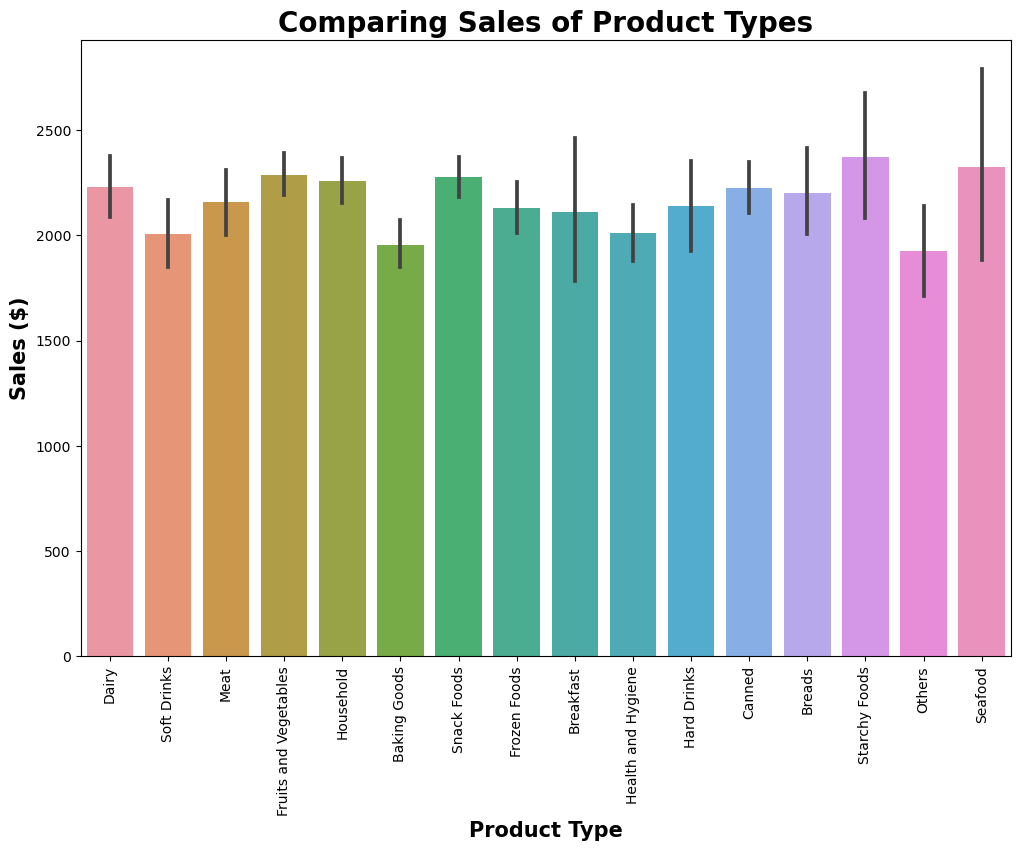

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df, x='Item_Type', y='Item_Outlet_Sales')
ax.tick_params(axis='x', rotation=90)
ax.set_title("Comparing Sales of Product Types", fontsize=20, fontweight='bold');
ax.set_xlabel('Product Type', fontsize=15, fontweight='bold')
ax.set_ylabel('Sales ($)', fontsize=15, fontweight='bold');

- The bar graph above shows that starchy foods has the highest profits.

# (Core) Project 1 Revisited: Importances and Coefficients

## Task
- For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.

## Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models
For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.2. You should continue to save your work in the same repo as your original Project 1. 

- Create a new notebook called "Project 1 - Revisited.ipynb" in your original project repo.
 - You may either make a copy of your prior notebook that you will modify,
or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

In [22]:
# Reload original dataframe
df2 = pd.read_csv('Data/sales_predictions_2023.csv')
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [23]:
# Confirm new dataframe is the original version
df2.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Train_Test_Split

In [24]:
# Make X and y variables
y = df2['Item_Outlet_Sales'].copy()
X = df2.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier']).copy()
# Train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,1998,NaN,Tier 3,Grocery Store
7604,6.135,LF,0.079294,Soft Drinks,111.2860,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,2004,Small,Tier 2,Supermarket Type1
6464,5.945,LF,0.093009,Household,127.8652,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,2004,Small,Tier 2,Supermarket Type1


### Preprocessing 


In [25]:
# Make categorical selector and verify it works
cat_select = make_column_selector(dtype_include='object')
cat_select(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [26]:
# Make numeric selector and verify it works
num_select = make_column_selector(dtype_include='number')
num_select(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [27]:
# Make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='N/A'),
                        OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

### Columntransformer

In [28]:
# Make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_select),
                                       (cat_pipe, cat_select),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000234A2A5A7F0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000234A2A5A400>)],
                  verbose_feature_names_out=False)

### Extract Feature Names from Columntransfomer

In [29]:
# Fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_N/A',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Ty

### Remake your X_train and X_test as DataFrames with the Feature Names

In [30]:
# Convert training data into dataframe
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_N/A,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220,0.064142,61.2510,1998.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150,0.028593,151.0708,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200,0.066285,247.2092,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# Convert test data into dataframe
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_N/A,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.250000,0.061531,132.2968,2007.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.850000,0.044463,127.1020,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.270000,0.071078,114.2518,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4608,12.822634,0.075142,145.8444,1985.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5544,13.500000,0.121633,161.6920,1998.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [32]:
# Confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

## LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
 - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

In [33]:
# Create custom function for regression evaluation
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [34]:
# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1114.87
Test Data:	R^2= 0.56	RMSE= 1164.39


### Extract and Save the Coefficients from the Model

In [35]:
# Display coefficients
lin_reg.coef_

array([ 1.09457524e+00, -2.79839968e+02,  1.55974651e+01,  3.64898474e+01,
       -2.78975700e+01,  4.99154419e+00,  4.01253879e+01,  5.90520310e+01,
       -7.62713931e+01,  9.47069413e+00, -6.18867360e+00,  6.84483495e+01,
        2.21663142e+01, -4.93951633e+01, -4.43958322e+00,  1.65738269e+01,
        4.87151860e+01, -4.13777644e+01, -6.86731589e+01, -1.56812363e+01,
        1.89380121e+01,  9.50514453e+01, -1.14823711e+01, -1.17195239e+02,
        3.50693612e+01,  6.15027999e+02, -1.41287455e+02, -3.15344302e+02,
       -1.58396242e+02,  1.49283681e+02,  4.96661223e+01, -1.98949803e+02,
       -1.52645027e+03, -9.67506708e+01, -4.68493299e+02,  2.09169424e+03])

In [36]:
# Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

36


36

In [37]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index = feature_names)
coeffs

Item_Weight                           1.094575
Item_Visibility                    -279.839968
Item_MRP                             15.597465
Outlet_Establishment_Year            36.489847
Item_Fat_Content_LF                 -27.897570
Item_Fat_Content_Low Fat              4.991544
Item_Fat_Content_Regular             40.125388
Item_Fat_Content_low fat             59.052031
Item_Fat_Content_reg                -76.271393
Item_Type_Baking Goods                9.470694
Item_Type_Breads                     -6.188674
Item_Type_Breakfast                  68.448349
Item_Type_Canned                     22.166314
Item_Type_Dairy                     -49.395163
Item_Type_Frozen Foods               -4.439583
Item_Type_Fruits and Vegetables      16.573827
Item_Type_Hard Drinks                48.715186
Item_Type_Health and Hygiene        -41.377764
Item_Type_Household                 -68.673159
Item_Type_Meat                      -15.681236
Item_Type_Others                     18.938012
Item_Type_Sea

In [38]:
# Use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                            1.094575
Item_Visibility                     -279.839968
Item_MRP                              15.597465
Outlet_Establishment_Year             36.489847
Item_Fat_Content_LF                  -27.897570
Item_Fat_Content_Low Fat               4.991544
Item_Fat_Content_Regular              40.125388
Item_Fat_Content_low fat              59.052031
Item_Fat_Content_reg                 -76.271393
Item_Type_Baking Goods                 9.470694
Item_Type_Breads                      -6.188674
Item_Type_Breakfast                   68.448349
Item_Type_Canned                      22.166314
Item_Type_Dairy                      -49.395163
Item_Type_Frozen Foods                -4.439583
Item_Type_Fruits and Vegetables       16.573827
Item_Type_Hard Drinks                 48.715186
Item_Type_Health and Hygiene         -41.377764
Item_Type_Household                  -68.673159
Item_Type_Meat                       -15.681236
Item_Type_Others                      18

### Visualize the Coefficients

- Select the top 3 most impactful features and interpret their coefficients in plain English.

In [39]:
# Custom function for coefficient visualization
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

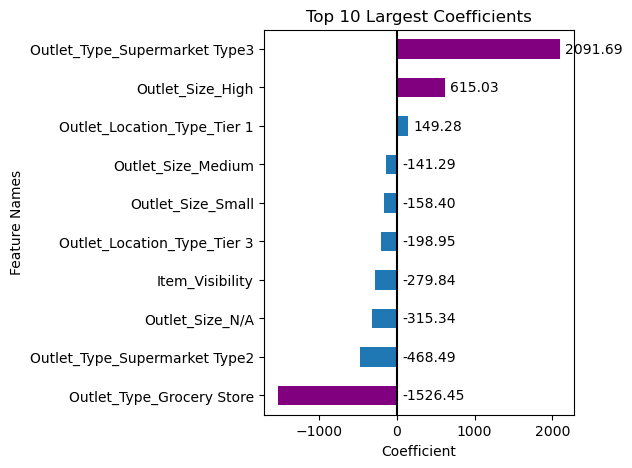

In [40]:
# Plot top 10 coeffs
ax = plot_coeffs(coeffs,top_n=10)
for bar in ax.patches:
    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height() / 2
    ## get the value to annotate
    val = bar.get_width()
    
    if val < 0:
        val_pos = 0
    else:
        val_pos = val
    
    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.2f}", (val_pos,bar_ax),
                ha='left', va='center',size=10,
                xytext=(4,0), textcoords='offset points')
# Highlight the top 3 most impactful features
highlight = ax.patches[9]
highlight2 = ax.patches[8]
highlight3 = ax.patches[0]
highlight.set_facecolor('purple')
highlight2.set_facecolor('purple')
highlight3.set_facecolor('purple')

### Interpreting The Model's Top 3 Most Impactful Coefficients:

- Intercept:
 - The model predicted that the sales profits for a product would be -$72,708.12 if the features for the product are 0.
- Coefficients that Positively Influence the Item Outlet Sales:
 - Outlet_Type_Supermarket_Type3 (Outlet Supermarket Type out of 3 options):
   - Products sold in these types outlet supermarkets (Type 3) increases item outlet sales by 2091.69 USD.
 - Outlet_Size_High (largest outlet size in terms of ground area covered):
   - Products sold in the high sized outlets increases item outlet sales by 615.03 USD.
- Coefficients the Negatively Influence the Item Outlet Sales:
 - Outlet_Type_Grocery_Store (outlet types that are grocery stores):
    - Products sold in outlet grocery stores decreases item outlet sales by 1526.45 USD.

### Save your figure as a .png file inside your repository 

![png](Data/top_coeffs.png)

## Tree-Based Model
- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
 - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

In [41]:
# Custom function to get important features
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [42]:
# Custom function to plot our importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

Training Data:	R^2= 0.94	RMSE= 427.27
Test Data:	R^2= 0.56	RMSE= 1170.43


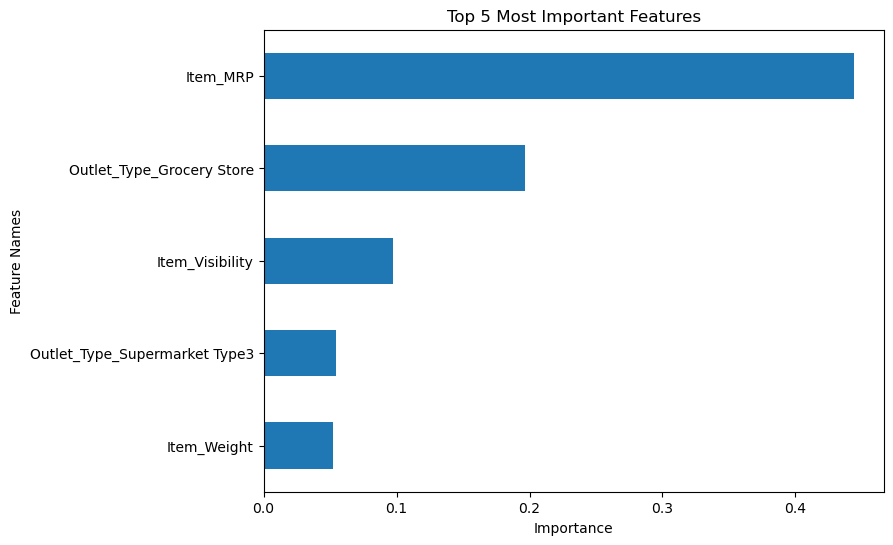

In [43]:
## fit random forest model
random = RandomForestRegressor()
random.fit(X_train_df,y_train)
evaluate_regression(random, X_train_df, y_train, X_test_df,y_test)
## Saving the feature importances
importances = get_importances(random)
plot_importance(importances, top_n=5);

## Identifying and Interpreting the top 5 most important features:



In [44]:
# Combine train and test dataframes for plotting our important featues
plot_train = pd.concat([X_train_df, y_train], axis=1)
plot_test = pd.concat([X_test_df, y_test], axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_N/A,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
8269,7.220,0.064142,61.2510,1998.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,126.5020
7604,6.135,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2263.7200
2762,12.150,0.028593,151.0708,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2858.9452
6464,5.945,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2195.8084
4707,18.200,0.066285,247.2092,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3486.1288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,12.850,0.033247,172.4422,2002.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4483.4972
5323,17.250,0.037338,163.7526,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3289.0520
22,14.600,0.025698,196.5084,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1587.2672
4526,13.850,0.034766,114.2492,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1853.5872


### Item_MRP (Max Retail Price - list price)

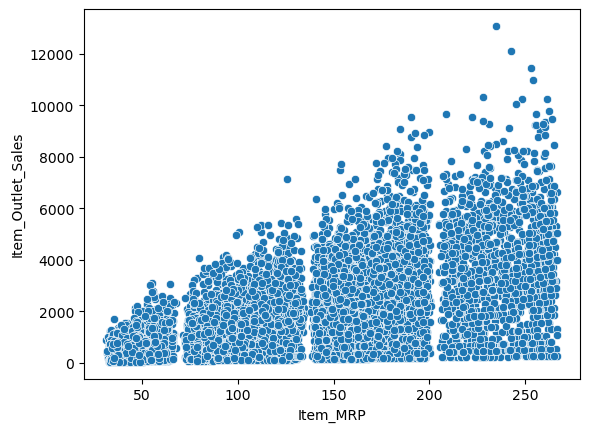

In [45]:
# Observing relationship between 'Item_MRP' and 'Item_Outlet_Sales'.
sns.scatterplot(data=plot_df, x='Item_MRP', y='Item_Outlet_Sales');

- Based on the scatterplot above, there is clearly a strong correlation between item outlet sales and item_MRP.
- The higher the list price on a sold product is, the more sales profits are earned.

### Outlet_Type_Grocery Store

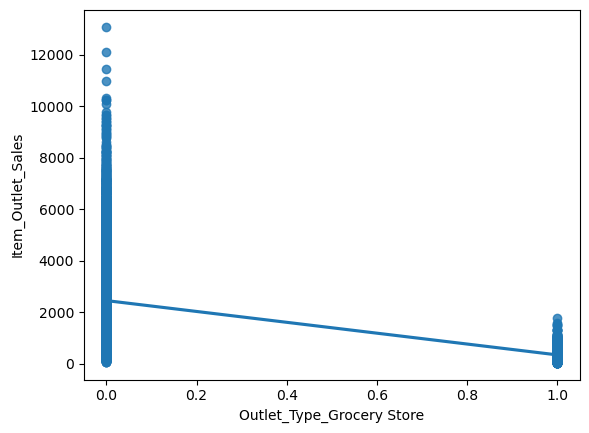

In [46]:
# Observing relationship between 'Outlet_Type_Grocery Store' and 'Item_Outlet_Sales'.
sns.regplot(data=plot_df, x='Outlet_Type_Grocery Store', y='Item_Outlet_Sales');

- The plot above shows outlet types that are not grocery stores earn more sales profits than outlet types that are.

### Item_Visibility

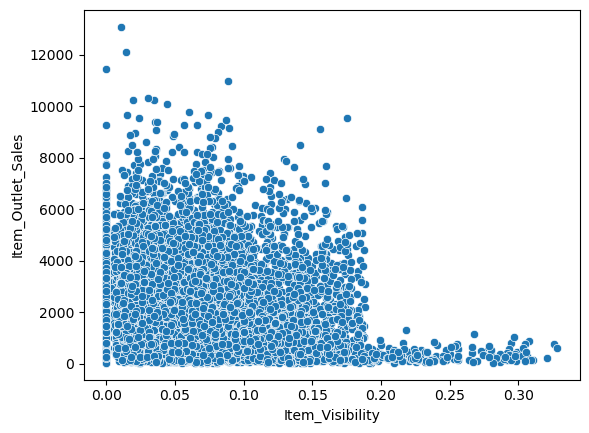

In [47]:
# Observing relationship between 'Item_Visibility' and 'Item_Outlet_Sales'.
sns.scatterplot(data=plot_df, x='Item_Visibility', y='Item_Outlet_Sales');

- There is a strong correlation between item visibility and item outlet sales. Less visible items are sold more compared to more visible items. Shoppers tend to purchase products already known to them than newer products that are given more display area.

### Item_Weight

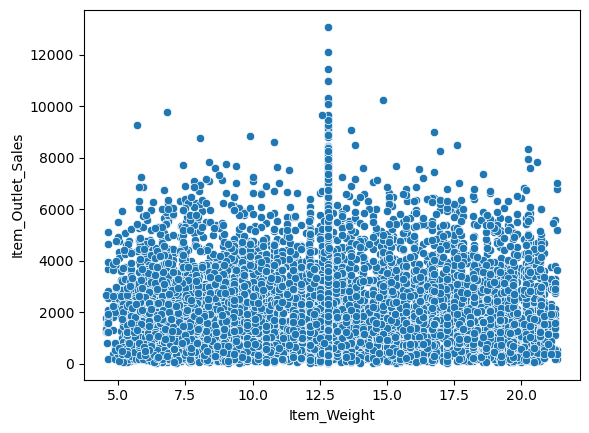

In [48]:
# Observing relationship between 'Item_Weight' and 'Item_Outlet_Sales'.
sns.scatterplot(data=plot_df, x='Item_Weight', y='Item_Outlet_Sales');

- Item weight does not have much of a correlation with item outlet sales. An item's weight does not have an impact whether it will be more or less likely to be sold.

### Outlet_Type_Supermarket Type3

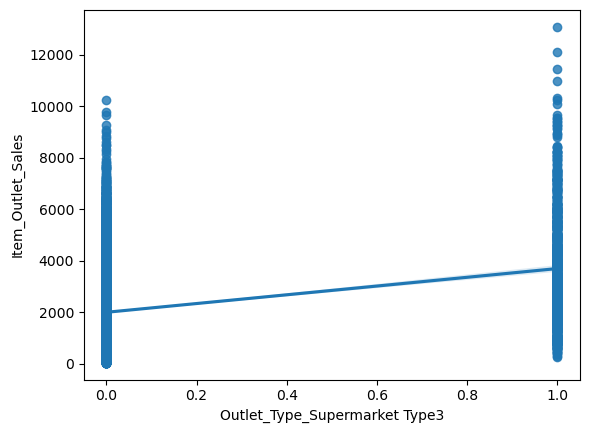

In [49]:
# Observing relationship between 'Outlet_Type_Supermarket Type3' and 'Item_Outlet_Sales'.
sns.regplot(data=plot_df, x='Outlet_Type_Supermarket Type3', y='Item_Outlet_Sales');

- Outlet types that are classified as Supermarket type 3 earn more item outlet sales than other supermarket types.

### Save your figure as a .png file inside your repository

![png](Data/most_important_features.png)

## Serialize Your Best Models with Joblib
- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
 - "preprocessor": your preprocessing  column transformer
 - "X_train": your training features.
 - "X_test": your test features.
 - "y_train": your training target.
 - "y_test": your test target.
 - "LinearRegression": your best linear regression
- Your tree-based model's class name: your best tree-based model.
    - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
- Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

In [50]:
# create a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression':lin_reg,
         'RandomForest':random}
joblib.dump(export, 'best_models.joblib')

['best_models.joblib']

### Confirming joblib file saved properly

In [51]:
# Load joblib file
final = joblib.load('best_models.joblib')
final.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForest'])

In [52]:
# Assign all keys to new variables
X_train_df = final['X_train']
y_train = final['y_train']
X_test_df = final['X_test']
y_test = final['y_test']
preprocessor = final['preprocessor']
lin_model = final['LinearRegression']
ran_model = final['RandomForest']

Training Data:	R^2= 0.94	RMSE= 427.27
Test Data:	R^2= 0.56	RMSE= 1170.43


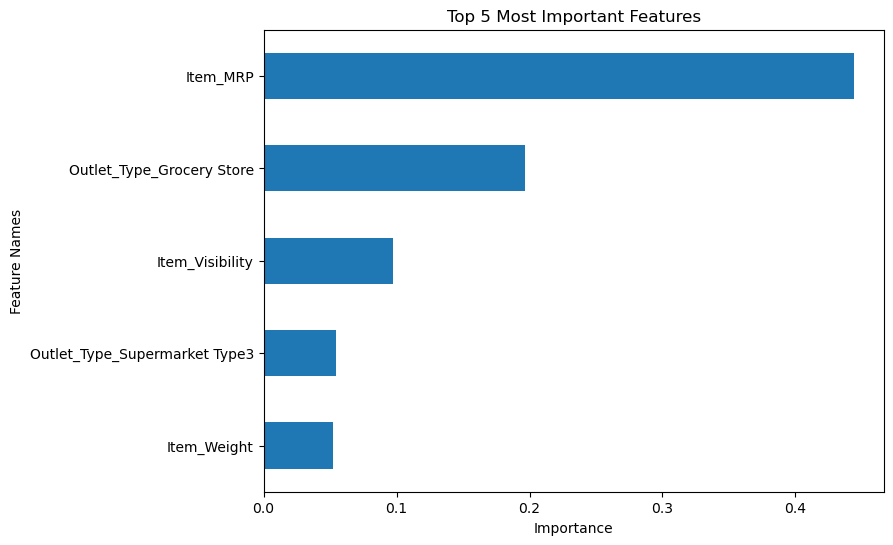

In [53]:
# Confirm results
evaluate_regression(ran_model, X_train_df, y_train, X_test_df,y_test)
ran_importances = get_importances(ran_model)
plot_importance(importances, top_n=5);

In [54]:
evaluate_regression(lin_model, X_train_df, y_train, X_test_df,y_test)
# Display coefficients
lin_model.coef_

Training Data:	R^2= 0.56	RMSE= 1114.87
Test Data:	R^2= 0.56	RMSE= 1164.39


array([ 1.09457524e+00, -2.79839968e+02,  1.55974651e+01,  3.64898474e+01,
       -2.78975700e+01,  4.99154419e+00,  4.01253879e+01,  5.90520310e+01,
       -7.62713931e+01,  9.47069413e+00, -6.18867360e+00,  6.84483495e+01,
        2.21663142e+01, -4.93951633e+01, -4.43958322e+00,  1.65738269e+01,
        4.87151860e+01, -4.13777644e+01, -6.86731589e+01, -1.56812363e+01,
        1.89380121e+01,  9.50514453e+01, -1.14823711e+01, -1.17195239e+02,
        3.50693612e+01,  6.15027999e+02, -1.41287455e+02, -3.15344302e+02,
       -1.58396242e+02,  1.49283681e+02,  4.96661223e+01, -1.98949803e+02,
       -1.52645027e+03, -9.67506708e+01, -4.68493299e+02,  2.09169424e+03])